In [1]:
import pandas as pd
import cv2
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split

import warnings
warnings.filterwarnings(action='ignore')

## load data

In [2]:
train = pd.read_csv('/data/train.csv')
test = pd.read_csv('/data/test.csv')
sample_submission = pd.read_csv('/data/sample_submission.csv')
train.head()

,img_id,img_path,airplane,airport,bare soil,baseball diamond,basketball court,beach,bridge,buildings,...,tanks,tennis court,terrace,track,trail,transmission tower,trees,water,wetland,wind turbine
0,000L8TYE,./train/000L8TYE.jpg,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,1,1,0,0
1,0035QTK9,./train/0035QTK9.jpg,0,0,1,0,0,0,0,1,...,0,0,0,0,0,0,1,0,0,0
2,00470HEH,./train/00470HEH.jpg,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,1,0,0,0
3,004CCB2Q,./train/004CCB2Q.jpg,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,1,1,0,0
4,005AY4ES,./train/005AY4ES.jpg,0,0,1,0,0,0,0,0,...,0,0,0,0,1,0,1,1,0,0


## rewrite image path

In [3]:
def rewrite(df):
    df['img_path'] = '/data/' + df['img_path']
    return df

dfs = [train, test]
dfs = [rewrite(df) for df in dfs]
train, test = dfs

In [4]:
# 중복 데이터 X
print(len(train) == len(train.drop_duplicates('img_id')))

True


## Plot Images

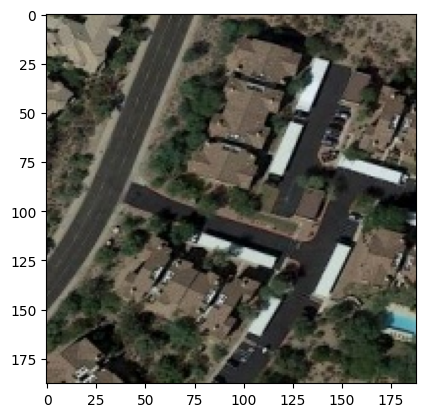

buildings, cars, dense residential area, grass, pavement, road, swimming pool, trees, water


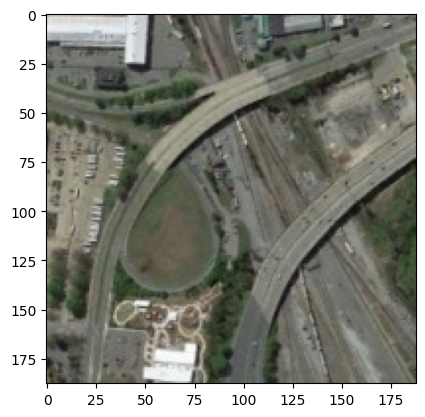

bare soil, buildings, cars, factory, overpass, parking lot, pavement, road, trees


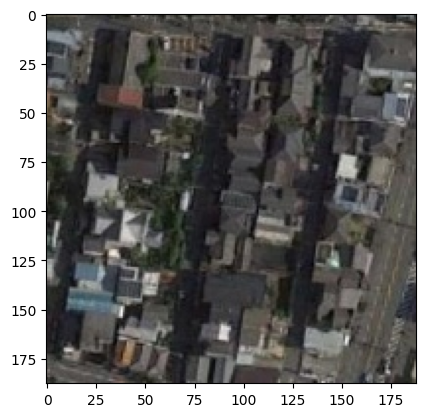

buildings, cars, dense residential area, grass, pavement, road, trees


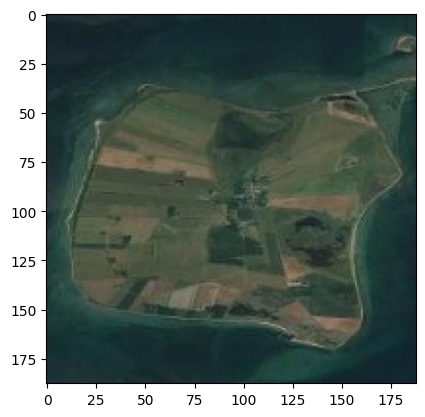

bare soil, grass, island, sea, trees, water


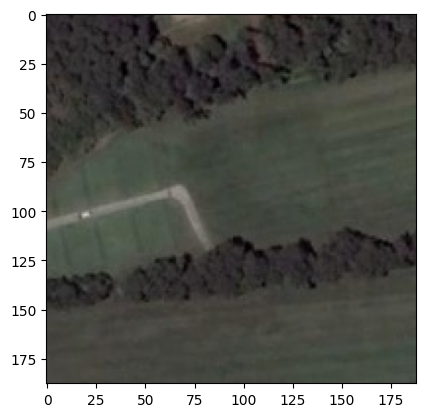

bare soil, golf course, grass, trail, trees, water


In [5]:
def display_image_and_label(df, idx):
    img = cv2.imread(df['img_path'].iloc[idx])
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.show()
    print(*df.iloc[idx][df.iloc[idx] == 1].index, sep=', ')

for i in range(5):
    display_image_and_label(train, i)

## Multi Label
ex. 3개의 label이 동시에 존재하는 이미지의 수: 10198

In [6]:
multilabel = train.drop(columns=['img_path', 'img_id']).sum(axis=1).value_counts().reset_index().values

for idx, count in multilabel:
    print(f"{idx} - {count}")

3 - 10198
5 - 9656
6 - 8956
2 - 8222
4 - 8023
7 - 7057
8 - 4705
9 - 3213
1 - 1922
10 - 912
25 - 561
38 - 521
24 - 296
39 - 283
12 - 265
11 - 232
26 - 182
23 - 82
37 - 78
22 - 30
40 - 28
13 - 26
36 - 19
20 - 9
19 - 7
0 - 5
21 - 3
35 - 2
14 - 2
18 - 1


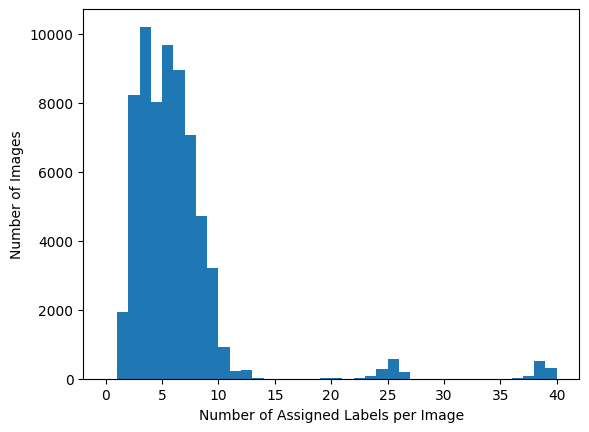

In [7]:
plt.hist(multilabel[:, 0], weights=multilabel[:, 1], bins=40)
plt.xlabel("Number of Assigned Labels per Image")
plt.ylabel("Number of Images")
plt.show()

## Correlation of labels

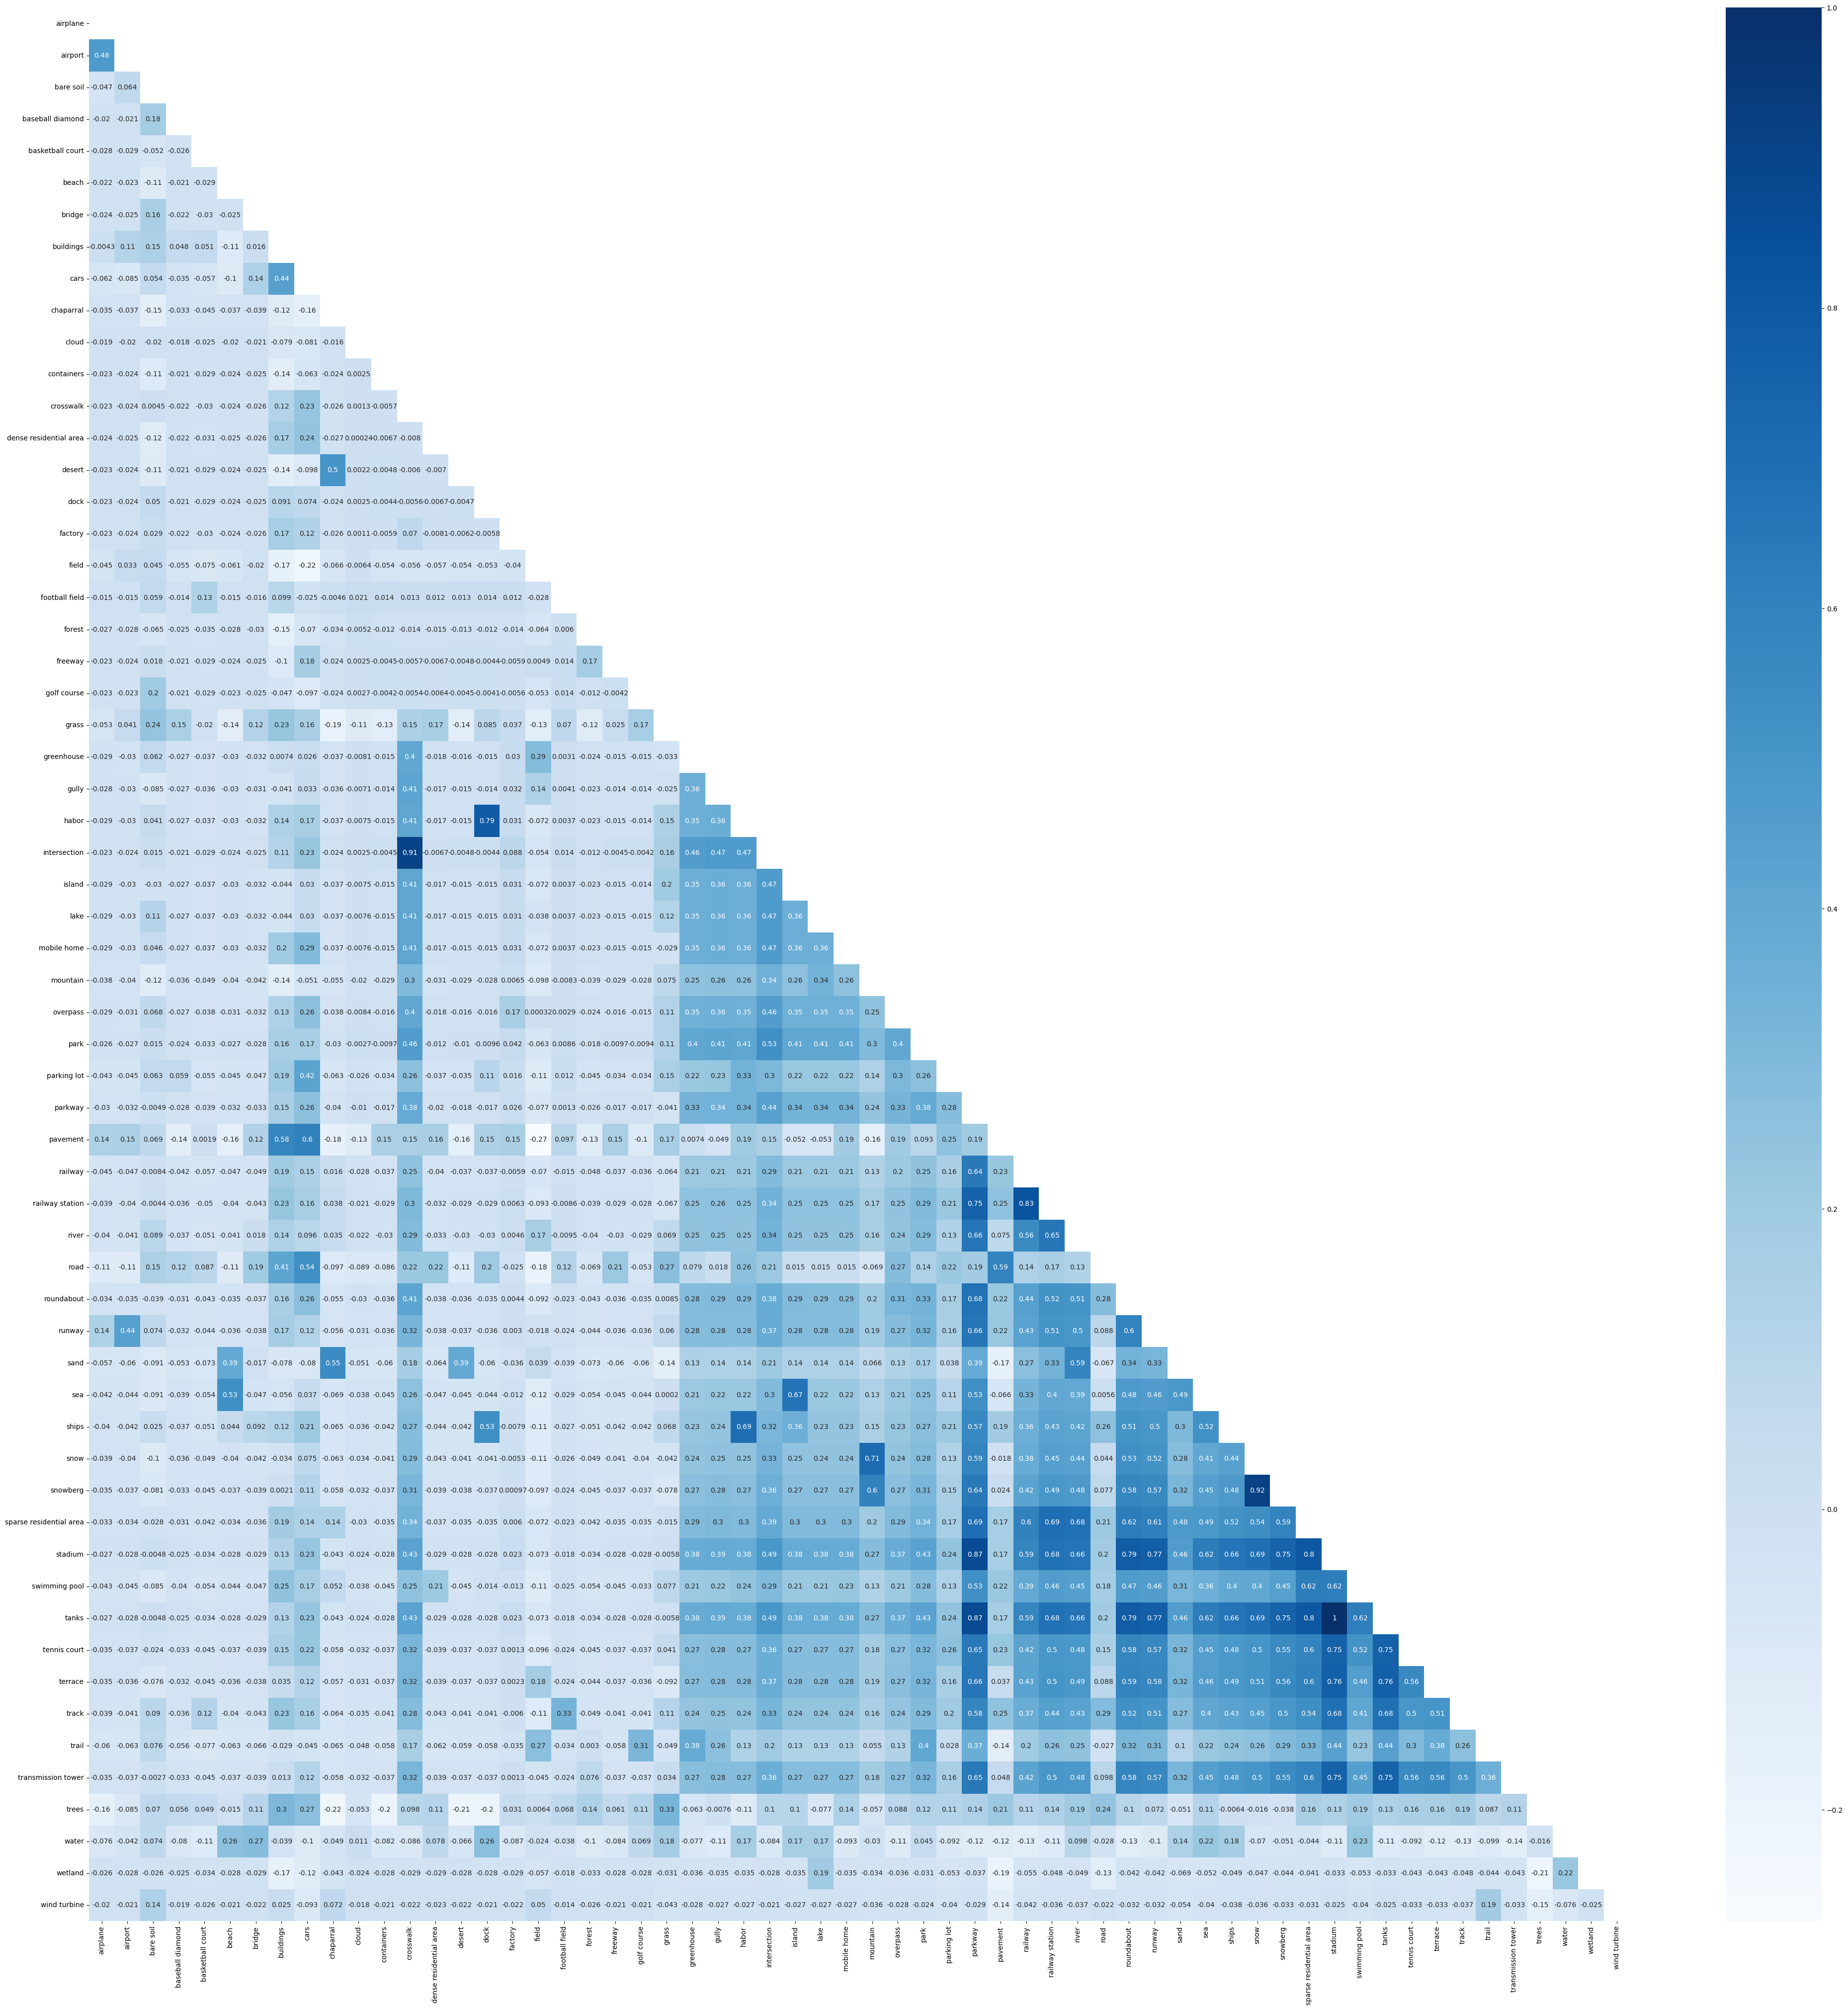

In [8]:
corr_df = train.drop(columns=['img_path', 'img_id']).corr()

mask = np.triu(np.ones_like(corr_df, dtype=bool))

plt.figure(figsize = (50,50))
sns.heatmap(corr_df, mask=mask, annot=True, cmap='Blues')
plt.show()

## Image Size

In [9]:
# Image는 모두 188 x 188
img_sizes = np.array([Image.open(path).size for path in train['img_path'][:5]])
H, W = img_sizes[:,1], img_sizes[:,0]

print(f"mean: {np.mean(H)}, std: {np.std(H)}")
print(f"mean: {np.mean(W)}, std: {np.std(W)}")

mean: 188.0, std: 0.0
mean: 188.0, std: 0.0


## proportion of each class

In [10]:
def print_and_calculate_pro(df, return_values=False):
    ALL = len(df)
    percent_values = (df.iloc[:, 2:].mean() * 100).values
    
    if not return_values:
        for i, col in enumerate(df.columns[2:], 1):
            print(f"{i}. {col}: {percent_values[i-1]:.2f} %")
    
    return percent_values

# Class별 비율 출력
_ = print_and_calculate_pro(train)

1. airplane: 2.11 %
2. airport: 2.28 %
3. bare soil: 35.95 %
4. baseball diamond: 1.83 %
5. basketball court: 3.41 %
6. beach: 2.28 %
7. bridge: 2.53 %
8. buildings: 47.02 %
9. cars: 31.16 %
10. chaparral: 5.43 %
11. cloud: 1.69 %
12. containers: 2.33 %
13. crosswalk: 2.47 %
14. dense residential area: 2.59 %
15. desert: 2.37 %
16. dock: 2.33 %
17. factory: 2.49 %
18. field: 13.88 %
19. football field: 1.01 %
20. forest: 3.33 %
21. freeway: 2.33 %
22. golf course: 2.30 %
23. grass: 45.25 %
24. greenhouse: 3.80 %
25. gully: 3.63 %
26. habor: 3.70 %
27. intersection: 2.33 %
28. island: 3.70 %
29. lake: 3.71 %
30. mobile home: 3.71 %
31. mountain: 6.43 %
32. overpass: 3.85 %
33. park: 2.96 %
34. parking lot: 7.86 %
35. parkway: 4.14 %
36. pavement: 51.72 %
37. railway: 8.51 %
38. railway station: 6.51 %
39. river: 6.76 %
40. road: 34.66 %
41. roundabout: 5.04 %
42. runway: 5.23 %
43. sand: 13.23 %
44. sea: 7.72 %
45. ships: 6.90 %
46. snow: 6.45 %
47. snowberg: 5.51 %
48. sparse residenti

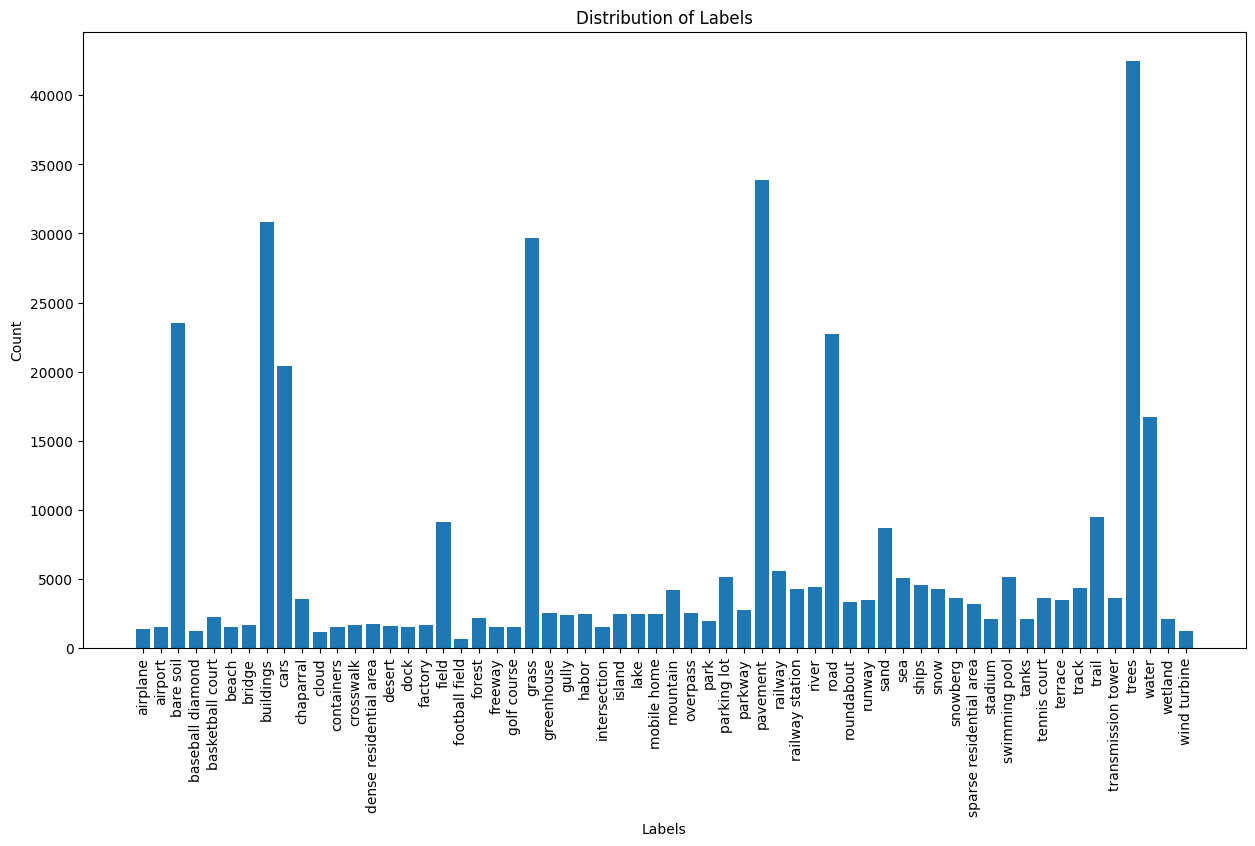

In [11]:
def plot_label_distribution(df):
    label_counts = df.iloc[:, 2:].sum()

    plt.figure(figsize=(15, 8))
    plt.bar(label_counts.index, label_counts.values)
    plt.xlabel('Labels')
    plt.ylabel('Count')
    plt.title('Distribution of Labels')
    plt.xticks(rotation=90)
    plt.show()

plot_label_distribution(train)

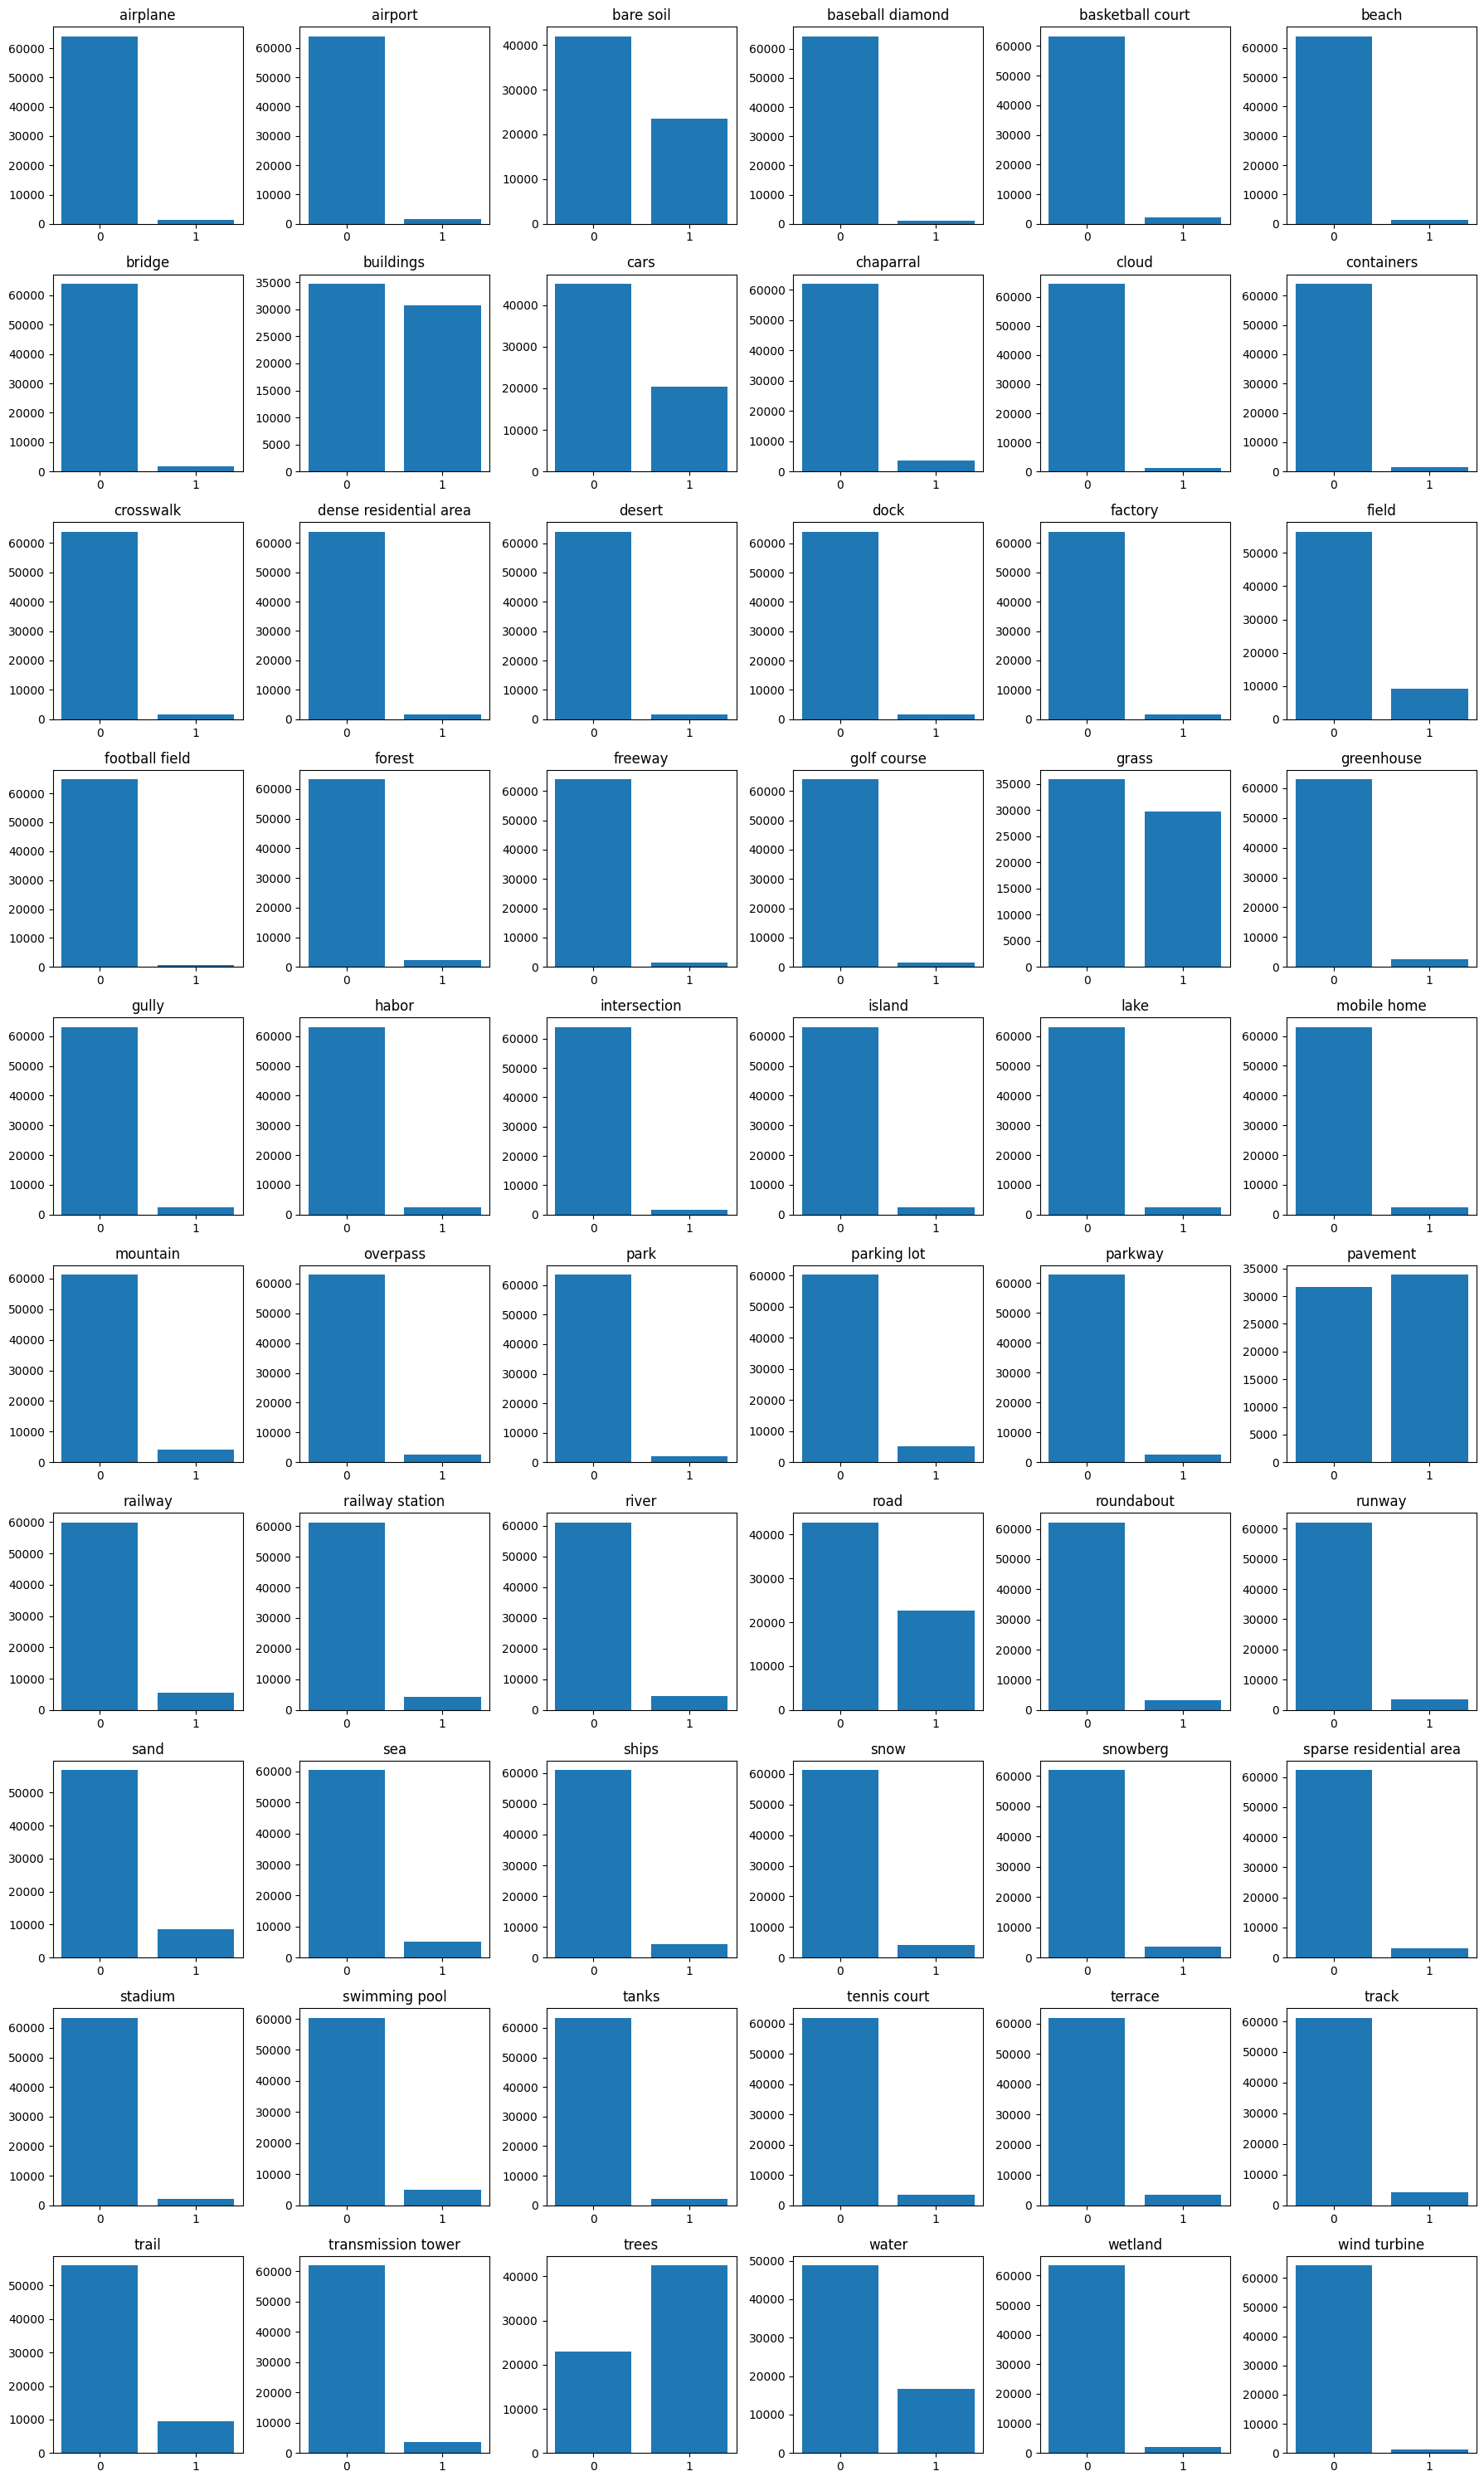

In [12]:
def plot_class_binary_distribution(df):
    fig, axs = plt.subplots(10, 6, figsize=(18, 30)) 
    axs = axs.ravel()

    for i, column in enumerate(df.columns[2:]): 
        counts = df[column].value_counts()
        axs[i].bar(counts.index, counts.values)
        axs[i].set_title(column)
        axs[i].set_xticks([0, 1])

    # Remove unused subplots
    for j in range(i+1, 60): 
        fig.delaxes(axs[j])

    plt.tight_layout()
    plt.show()

plot_class_binary_distribution(train)


## train validation split

In [13]:
# train valid data split
train_, val_ = train_test_split(train, test_size=0.2)

# train과 validation의 class별 비율 차이 분포 출력
re_val = print_and_calculate_pro(val_, return_values=True)
re_train = print_and_calculate_pro(train_, return_values=True)

diff = re_train - re_val
print(diff.mean())
print(diff.std())

0.020074235995328094
0.2161128639828375
